In [1]:
import open3d
import numpy as np
import pandas as pd
import os
import tqdm
import copy
import glob

from scipy.signal import argrelmin
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

plt.rcParams.update({'font.size': 8})

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [20]:
dataset_dir = "data/features/"
experiment = "exp_10"
trial = "trial_1"
subject = "subject-1"
sequence = "01"
voxel_size = 0.03
out_dir ="data/trajectories/groundtruth/exp_10"
target_fps = 20
min_std = 0.5
cutoff_margin = 5

In [44]:
def find_candidate_global_pos(std_values, delta):
    global_pos = [0]
    prev_t = 0
    for current_t in range(len(std_values)):
        if np.abs(std_values[current_t] - std_values[prev_t]) > delta:
            global_pos.append(current_t)
            prev_t = current_t
            
    return global_pos

def find_cutoffs(std_values, target_fps, min_std):
    cutoffs = argrelmin(std_values, order=target_fps // 2)[0]
    return cutoffs[np.where(np.abs(std_values[cutoffs] - min_std) < 0.5)[0]]
    # return cutoffs[np.where(std_values[cutoffs] - min_std < 0)[0]]

In [6]:
file_name = f"{experiment}__{trial}__{subject}__{sequence}"

In [13]:
sequence_dir = f"data/raw_data/{experiment}/{trial}/secondary/{subject}/{sequence}/frames"

In [7]:
feature_dir = os.path.join(dataset_dir, experiment, trial, str(voxel_size), subject, sequence)
sequence_ts = fread.get_timstamps(feature_dir, ext=".secondary.npz")
num_frames = len(sequence_ts)

print("     :: Number of frames: {}".format(num_frames))

     :: Number of frames: 369


In [15]:
std_values = []

for t in range(len(sequence_ts)):
    depth_img = Image.open(os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png")).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

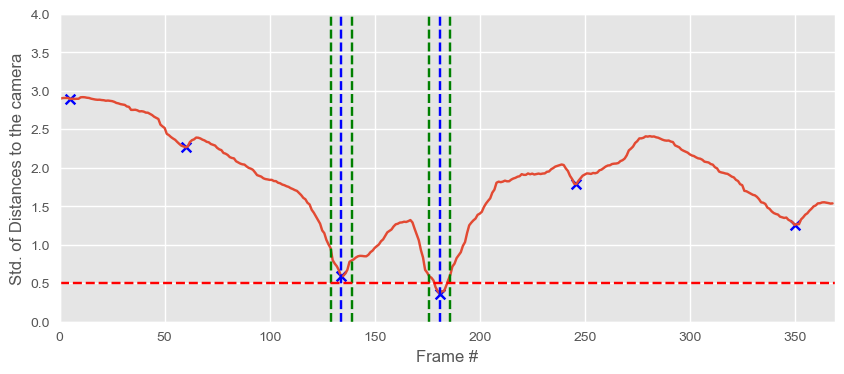

In [45]:
cutoffs = find_cutoffs(std_values, target_fps, min_std)
min_indices = argrelmin(std_values, order=target_fps // 2)[0]

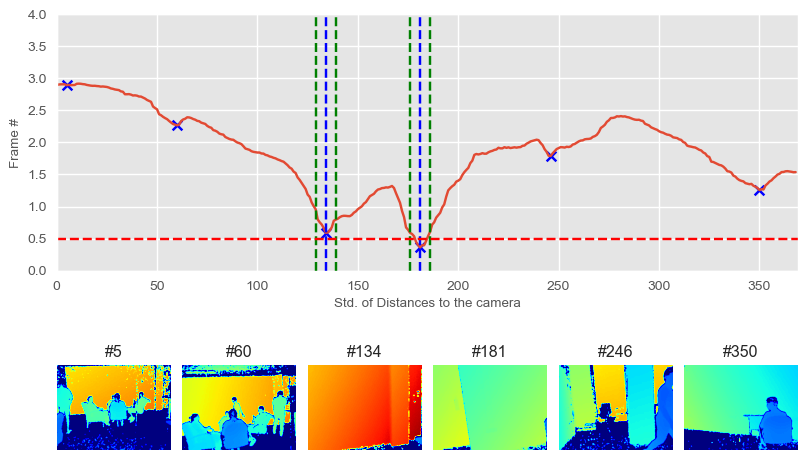

<Figure size 800x550 with 0 Axes>

In [48]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, len(min_indices))

ax = fig.add_subplot(gs[0, :])

ax.plot(std_values)
ax.scatter(min_indices, std_values[min_indices], c="b", marker="x")

for x in cutoffs:
    ax.axvline(x - cutoff_margin, c="g", linestyle="--")
    ax.axvline(x, c="b", linestyle="--")
    ax.axvline(x + cutoff_margin, c="g", linestyle="--")
    
ax.axhline(y=min_std, color="r", linestyle="--")
ax.set_ylim(0, 4)
ax.set_xlim(0, len(std_values))

ax.set_ylabel("Frame #")
ax.set_xlabel("Std. of Distances to the camera")

for i in range(len(min_indices)):
    ax = fig.add_subplot(gs[1, i])
    img = Image.open(os.path.join(sequence_dir, f"frame-{sequence_ts[min_indices[i]]}.depth.png")).convert("I").convert("I")
    ax.imshow(np.asarray(img), cmap="jet")
    ax.axis("off")
    ax.set_title(f"#{min_indices[i]}")

plt.show()
plt.tight_layout()